In [ ]:
!pip install --upgrade tensorflow
!pip install resampy
!pip install keras

In [2]:
#Audio Processing Libraries
import librosa
import librosa.display
from scipy import signal

#For Playing Audios
import IPython.display as ipd

#Array Processing
import numpy as np

#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Display the confusion matrix
from sklearn.metrics import confusion_matrix

#Deal with .pkl files
import pickle

#Create a dataframe
import pandas as pd

#Transform and encode the categorical targets
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

#Split dataset
from sklearn.model_selection import train_test_split

import os

In [3]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

#Demount if any changes made
#drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [4]:
def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=80)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)

    return mfccs_scaled_features

In [5]:
audio_dataset_path = "/content/drive/MyDrive/Siren_Data/"

extracted_features = []
for path in os.listdir(audio_dataset_path):
    for file in os.listdir(audio_dataset_path+path+"/"):
        if file.lower().endswith(".wav"):
            file_name = audio_dataset_path+path+"/"+file
            data = features_extractor(file_name)
            extracted_features.append([data, path])

In [6]:
f = open('./Extracted_Features.pkl', 'wb')
pickle.dump(extracted_features, f)
f.close()

In [7]:
f = open('./Extracted_Features.pkl', 'rb')
Data = pickle.load(f)
f.close()

In [8]:
#df = pd.read_csv("/content/drive/MyDrive/outputnew.csv", header=0)
df = pd.DataFrame(Data,columns=['feature','class'])
df.head()

,feature,class
0,"[-183.21304, 197.23341, -27.467678, 12.132657,...",traffic
1,"[-157.5472, 164.51596, -41.109306, 11.926925, ...",traffic
2,"[-151.16809, 180.87526, -18.24582, 20.400475, ...",traffic
3,"[-156.42455, 174.53667, -18.483446, 19.128778,...",traffic
4,"[-193.0595, 191.812, -28.586767, 15.74523, 4.4...",traffic


In [9]:
df['class'].value_counts()


police        227
traffic       200
firetruck     200
ambulance     200
tornado       200
fire alarm    200
Name: class, dtype: int64

In [10]:
X = np.array(df['feature'].tolist())
Y = np.array(df['class'].tolist())

In [11]:
type(Y)

numpy.ndarray

In [12]:
X.shape

(1227, 80)

In [13]:
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(Y))

In [ ]:
Y[0]


'traffic'

In [ ]:
y

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.]], dtype=float32)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y, shuffle=True)

In [15]:
y_train.shape


(981, 6)

In [16]:
X_train.shape


(981, 80)

In [17]:
X_test.shape


(246, 80)

In [18]:
y_test.shape


(246, 6)

In [19]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from keras import backend as K
from sklearn import metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import StandardScaler
#from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from datetime import datetime


In [20]:
#x_train_features  = X_train.reshape(len(X_train),-1, 80)
x_train_features = X_train.reshape(len(X_train), -1, 80)
x_test_features = X_test.reshape(len(X_test), -1, 80)
print("Reshaped Array Size", x_train_features.shape)

Reshaped Array Size (981, 1, 80)


In [21]:
def lstm(x_tr):
    K.clear_session()
    inputs = Input(shape=(x_tr.shape[1], x_tr.shape[2]))
    #lstm
    x = LSTM(128)(inputs)
    x = Dropout(0.5)(x)
    #dense
    x = Dense(64, activation='relu')(x)
    x = Dense(y_test.shape[1], activation='softmax')(x)
    model = Model(inputs, x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return model


In [22]:
model_lstm = lstm(x_train_features)
model_lstm.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 80)]           0         
                                                                 
 lstm (LSTM)                 (None, 128)               107008    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 115654 (451.77 KB)
Trainable params: 115654 (451.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


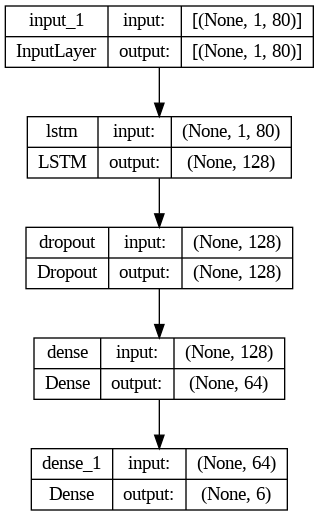

In [23]:
from tensorflow.keras.utils import plot_model
plot_model(model_lstm, show_shapes=True, show_layer_names=True)

In [24]:
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [25]:
history = model_lstm.fit(x_train_features, y_train, epochs = 1000,
                        callbacks = [mc],
                        batch_size = 64, validation_data = (x_test_features, y_test))

Epoch 1/1000
12/16 [=====================>........] - ETA: 0s - loss: 0.6177 - acc: 0.2721
Epoch 1: val_acc improved from -inf to 0.41870, saving model to best_model.hdf5
16/16 [==============================] - 4s 60ms/step - loss: 0.5919 - acc: 0.2915 - val_loss: 0.4486 - val_acc: 0.4187
Epoch 2/1000
15/16 [===========================>..] - ETA: 0s - loss: 0.4138 - acc: 0.4437

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_acc improved from 0.41870 to 0.56504, saving model to best_model.hdf5
16/16 [==============================] - 0s 15ms/step - loss: 0.4126 - acc: 0.4465 - val_loss: 0.3539 - val_acc: 0.5650
Epoch 3/1000
15/16 [===========================>..] - ETA: 0s - loss: 0.3421 - acc: 0.6167
Epoch 3: val_acc improved from 0.56504 to 0.75203, saving model to best_model.hdf5
16/16 [==============================] - 0s 13ms/step - loss: 0.3415 - acc: 0.6188 - val_loss: 0.2853 - val_acc: 0.7520
Epoch 4/1000
15/16 [===========================>..] - ETA: 0s - loss: 0.2832 - acc: 0.7198
Epoch 4: val_acc improved from 0.75203 to 0.78862, saving model to best_model.hdf5
16/16 [==============================] - 0s 13ms/step - loss: 0.2827 - acc: 0.7217 - val_loss: 0.2313 - val_acc: 0.7886
Epoch 5/1000
14/16 [=========================>....] - ETA: 0s - loss: 0.2298 - acc: 0.7891
Epoch 5: val_acc improved from 0.78862 to 0.81707, saving model to best_model.hdf5
16/16 [===========================

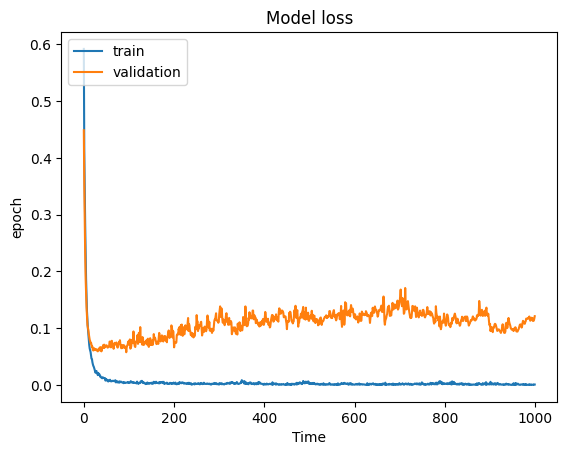

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Time')
plt.ylabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [27]:
_,acc = model_lstm.evaluate(x_test_features, y_test)
print("Accuracy:", acc)

8/8 [==============================] - 0s 4ms/step - loss: 0.1212 - acc: 0.9472
Accuracy: 0.9471544623374939


8/8 [==============================] - 1s 5ms/step


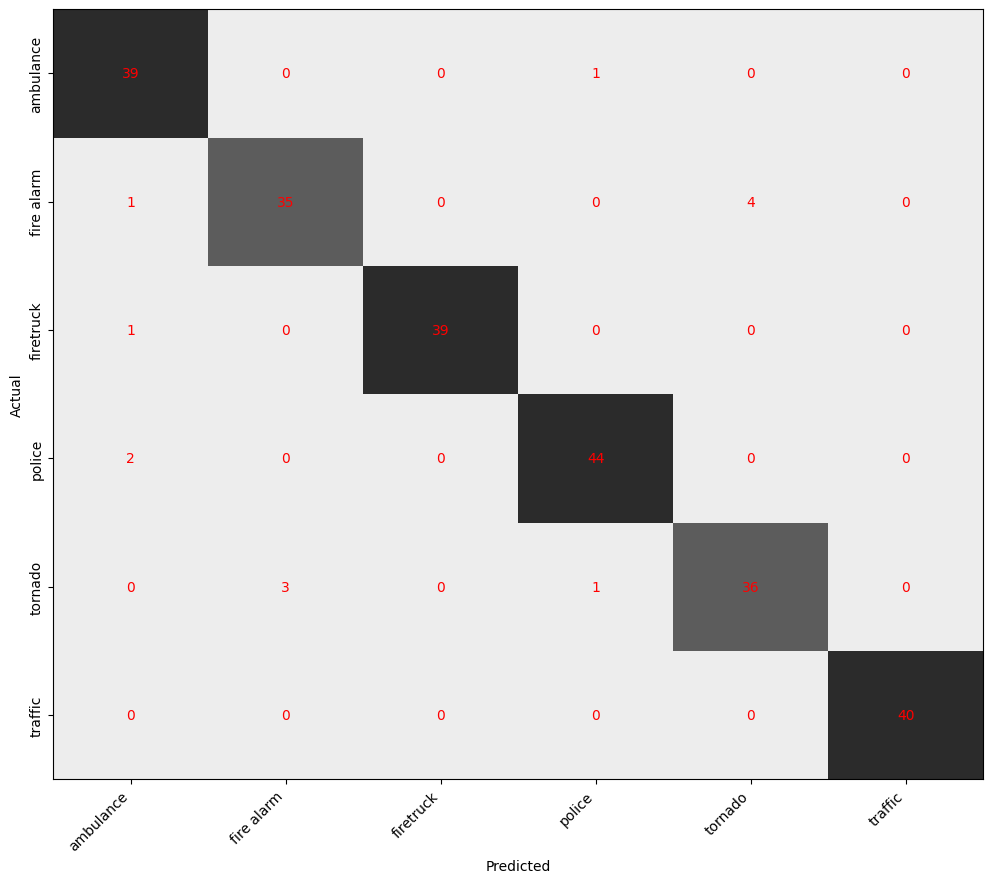

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
y_pred = model_lstm.predict(x_test_features)
conf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

# Create a custom color map (black)
cmap = sns.color_palette("Greys", desat=1)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=labelencoder.classes_, yticklabels=labelencoder.classes_, cbar=False, cmap=cmap, annot_kws={"color": "red"})

# Set the text color to red
for _, spine in ax.spines.items():
    spine.set_visible(True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_yticklabels(ax.get_yticklabels())

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [29]:
y_test1=y_test.tolist()
y_test2 = []
for sublist in y_test1:
  if sublist[0]==1:
    y_test2.append(0)
  elif sublist[1]==1:
    y_test2.append(1)
  elif sublist[2]==1:
    y_test2.append(2)
  elif sublist[3]==1:
    y_test2.append(3)
  elif sublist[4]==1:
    y_test2.append(4)
  elif sublist[5]==1:
    y_test2.append(5)

y_pred3=np.argmax(y_pred, axis=1)
y_pred2=y_pred3.tolist()


In [30]:
from sklearn.metrics import classification_report
classes = ["ambulance", "firetruck", "traffic", "police", "tornado", "fire_alarm"]
print(classification_report(y_test2, y_pred2, target_names=classes))

              precision    recall  f1-score   support

   ambulance       0.91      0.97      0.94        40
   firetruck       0.92      0.88      0.90        40
     traffic       1.00      0.97      0.99        40
      police       0.96      0.96      0.96        46
     tornado       0.90      0.90      0.90        40
  fire_alarm       1.00      1.00      1.00        40

    accuracy                           0.95       246
   macro avg       0.95      0.95      0.95       246
weighted avg       0.95      0.95      0.95       246



In [31]:
model_lstm.save('./LSTM')